In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import geopy
from pprint import pprint
from geopy.distance import geodesic
from tqdm import tqdm
import scipy
plt.rcParams["figure.dpi"] = 100

sys.path.insert(1, '../src/')
import utils

### Data Loading
- 100Hz
- Ground truth RTK-GPS coordinates with augmented left and right lane markings

Note:
- Using left lane, left lanemarking for algorithm testing and evaluation

In [2]:
ll_marks = pd.read_csv('../data/acm_track/augmented_lane_line/ll_lane.csv.gzip', compression='gzip', index_col=0)
rl_marks = pd.read_csv('../data/acm_track/augmented_lane_line/rl_lane.csv.gzip', compression='gzip', index_col=0)

ll_marks = ll_marks[['y', 'x', 'Vx', 'left_mark_lat', 'left_mark_lon', 'right_mark_lat', 'right_mark_lon', 'Distance horizontal (m)']]
rl_marks = rl_marks[['y', 'x', 'Vx', 'left_mark_lat', 'left_mark_lon', 'right_mark_lat', 'right_mark_lon', 'Distance horizontal (m)']]

In [4]:
# points per meter ~= 20
ll_marks.shape[0] / ll_marks['Distance horizontal (m)'].values[-1], rl_marks.shape[0] / rl_marks['Distance horizontal (m)'].values[-1]

(19.111790358365297, 21.909061145434567)

### GPS Sampling

- 100Hz to 10Hz

In [58]:
ll_sampled_noise = sample_gps(ll_marks, sampling_rate=10)
rl_sampled_noise = sample_gps(rl_marks, sampling_rate=10)

print(ll_sampled_noise.shape)

(7082, 8)


In [6]:
ll_sampled_noise[(ll_sampled_noise['Distance horizontal (m)'] >= 100) & (ll_sampled_noise['Distance horizontal (m)'] <= 110)].shape[0]

20

### GPS Noise Augmentation

- https://wiki.gis.com/wiki/index.php/Decimal_degrees
- 5 decimal places corresponds to an accuracy of 1.11 meters (+/- 0.55m) at the equator

#### scratch work

In [8]:
np.random.seed(0)
seeds = np.random.randint(10, size=3)

for seed in seeds:
    np.random.seed(seed)
    print(np.random.randint(5))

3
4
2


(array([ 1.,  5.,  7., 13., 17., 18., 16., 11.,  7.,  5.]),
 array([-1.27649491e-05, -1.03535769e-05, -7.94220464e-06, -5.53083242e-06,
        -3.11946020e-06, -7.08087980e-07,  1.70328424e-06,  4.11465646e-06,
         6.52602868e-06,  8.93740090e-06,  1.13487731e-05]),
 <BarContainer object of 10 artists>)

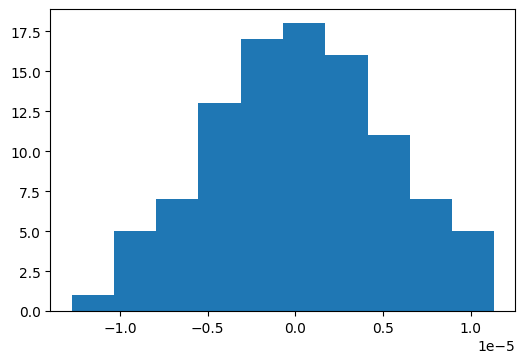

In [9]:
np.random.seed(0)
plt.hist(0.00001 * 1/2 * np.random.randn(100))

#### Noise Augmentation

In [59]:
colns = ['left_mark_lat', 'left_mark_lon', 'right_mark_lat', 'right_mark_lon']
ll_sampled_noise = gps_noise_augmentation(ll_sampled_noise, 0.000005, colns, seed=1)
rl_sampled_noise = gps_noise_augmentation(rl_sampled_noise, 0.000005, colns, seed=2)

Random seeds = [5 8 9 5]
Random seeds = [8 8 6 2]


In [8]:
def traj_gps_error(traj_df, colns1, colns2) -> np.ndarray:
    """
    calculates the GPS coordinate error between (colns1.lat, colns1.lon) and (colns2.lat, colns2.lon)
    distance metric: geodesic
    """
    error = []
    lat1 = traj_df[colns1[0]].values
    lon1 = traj_df[colns1[1]].values

    if type(colns2[0]) == str:    
        lat2 = traj_df[colns2[0]].values
        lon2 = traj_df[colns2[1]].values
    else:
        lat2 = colns2[0] * np.ones_like(lat1)
        lon2 = colns2[1] * np.ones_like(lon1)

    def get_distance(lat1, lon1, lat2, lon2):
        point1 = (lat1, lon1)
        point2 = (lat2, lon2)
        return geodesic(point1, point2).meters
    
    error = np.vectorize(get_distance)(
        lat1, lon1, lat2, lon2
    )
    return error

In [9]:
# left lane, left lanemark

ll_mark_error_l = traj_gps_error(
    ll_sampled_noise, 
    colns1=['left_mark_lat', 'left_mark_lon'], colns2=['left_mark_lat_noise', 'left_mark_lon_noise']
)

# unit [m]
pprint(ll_mark_error_l.mean())
pprint(ll_mark_error_l.std())

0.2283798921294963
0.16373160031940776


In [13]:
# left lane, right lanemark

ll_mark_error_r = traj_gps_error(
    ll_sampled_noise, 
    colns1=['right_mark_lat', 'right_mark_lon'], colns2=['right_mark_lat_noise', 'right_mark_lon_noise']
)

pprint(ll_mark_error_r.mean())
pprint(ll_mark_error_r.std())

0.2267288010150975
0.1683601904470513


In [10]:
# graph it
import plotly.graph_objects as go
fig = go.Figure()

# left lane left mark
fig.add_trace(go.Scatter(x=ll_sampled_noise['left_mark_lon'], y=ll_sampled_noise['left_mark_lat'],
                    mode='lines+markers', 
                    name='left marks: ground truth'))
fig.add_trace(go.Scatter(x=ll_sampled_noise['left_mark_lon_noise'], y=ll_sampled_noise['left_mark_lat_noise'],
                    mode='lines+markers', 
                    name='left marks: noise'))

fig.update_layout(
    showlegend=True,
    plot_bgcolor="white",
    margin=dict(t=10,l=10,b=10,r=10),
    width=700,
    height=500,
)

fig.update_layout(showlegend=True)
fig.show()

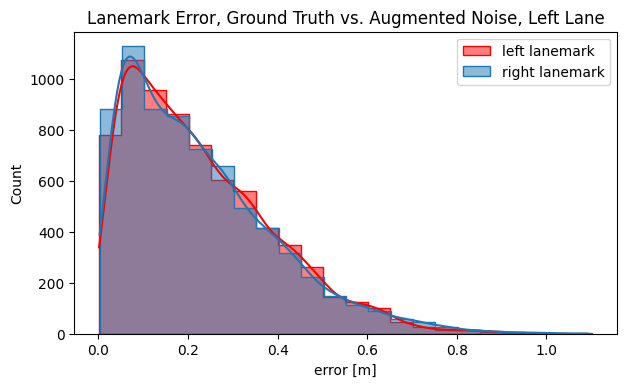

In [38]:
plt.figure(figsize=(7, 4), dpi=100)
sns.histplot(ll_mark_error_l, binwidth=0.05, label='left lanemark', kde=True, color='red', element = "step")
sns.histplot(ll_mark_error_r, binwidth=0.05, label='right lanemark', kde=True, element = "step")
plt.legend()
plt.xlabel('error [m]')
plt.title('Lanemark Error, Ground Truth vs. Augmented Noise, Left Lane')
plt.show()

## Method 1: Build Local Map from est. Point

- Using unsampled ground truth as reference
- Separate local search map for left and right lanemark

In [11]:
delta = 2 # [m]

In [12]:
def build_m(lane_ref: pd.DataFrame, point: geopy.Point, delta=2) -> pd.DataFrame:
    """
    build a boxed local search map with length delta [m] from point using the lane_ref
    returns the filtered reference points
    """
    
    bound1 = geodesic(meters=delta/2).destination(
        point, bearing=45
    )
    bound2 = geodesic(meters=delta/2).destination(
        point, bearing=225
    )

    local_map = lane_ref[
        (lane_ref['left_mark_lat'] <= bound1.latitude) &\
        (lane_ref['left_mark_lat'] >= bound2.latitude) &\
        (lane_ref['left_mark_lon'] <= bound1.longitude) &\
        (lane_ref['left_mark_lon'] >= bound2.longitude)
    ]
    
    assert local_map.shape[0] > 0, f'returned empty local map, ({point.latitude}, {point.longitude})'
    return local_map

In [13]:
def get_cloest_ref(local_map, point: geopy.Point) -> np.ndarray:
    """
    obtain the reference point with the minimum geodesic error distance to the estimated point
    """
    
    error = traj_gps_error(local_map, ['left_mark_lat', 'left_mark_lon'], [point.latitude, point.longitude])
    idx = np.argmin(error)
    cloest_ref = np.array([
        local_map['left_mark_lat'].values[idx], local_map['left_mark_lon'].values[idx]
    ])
    
    return cloest_ref

In [14]:
def map_matching(lane_ref, est, delta, lanemark='left'):
    """
    main function to perform map-matching and append the matched reference points in est
    """

    ref_opt_lat = []
    ref_opt_lon = []
    local_map_size = []

    for idx in tqdm(range(est.shape[0])):
        est_point = geopy.Point(est[f'{lanemark}_mark_lat_noise'].values[idx], 
                                est[f'{lanemark}_mark_lon_noise'].values[idx])
        try:
            local_map = build_m(lane_ref, est_point, delta)
        except:
            print('idx:', idx)
            break
            
        local_map_size.append(local_map.shape[0])
        ref_opt = get_cloest_ref(local_map, est_point)
        ref_opt_lat.append(ref_opt[0])
        ref_opt_lon.append(ref_opt[1])

    est['ref_opt_lat'] = ref_opt_lat
    est['ref_opt_lon'] = ref_opt_lon

    return est, local_map_size

In [17]:
ll_mapmatch, local_map_sizes = map_matching(ll_marks, ll_sampled_noise, delta=2)

100%|██████████| 7082/7082 [00:52<00:00, 136.01it/s]


In [19]:
# average local map size
# for delta=2, expect around 54

np.average(local_map_sizes)

54.39508613386049

In [20]:
ll_mapmatch_error_l = traj_gps_error(
    ll_mapmatch, 
    colns1=['left_mark_lat', 'left_mark_lon'], colns2=['ref_opt_lat', 'ref_opt_lon']
)
print(ll_mapmatch_error_l.mean(), ll_mapmatch_error_l.std())

0.2086307813619389 0.16286320633636495


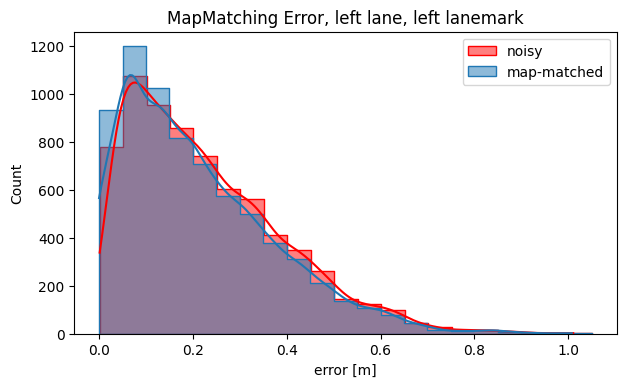

In [21]:
plt.figure(figsize=(7, 4), dpi=100)
sns.histplot(ll_mark_error_l, binwidth=0.05, label='noisy', kde=True, color='red', element = "step")
sns.histplot(ll_mapmatch_error_l, binwidth=0.05, label='map-matched', kde=True, element = "step")
plt.legend()
plt.xlabel('error [m]')
plt.title('MapMatching Error, left lane, left lanemark')
plt.show()

In [50]:
np.max(ll_mapmatch_error_l)

1.0077746507276393

In [40]:
delta = 2
sample = ll_mapmatch.iloc[np.argmax(ll_mapmatch_error_l)]
# sample = ll_mapmatch.iloc[1526]
point = geopy.Point(sample['left_mark_lat_noise'], sample['left_mark_lon_noise'])
point_gt = geopy.Point(sample['left_mark_lat'], sample['left_mark_lon'])
point_mm = geopy.Point(sample['ref_opt_lat'], sample['ref_opt_lon'])

bound1 = geodesic(meters=delta/2).destination(
        point, bearing=45
    )

bound2 = geodesic(meters=delta/2).destination(
        point, bearing=225
    )

local_map = ll_marks[(ll_marks['left_mark_lat'] <= bound1.latitude) &\
        (ll_marks['left_mark_lat'] >= bound2.latitude) &\
        (ll_marks['left_mark_lon'] <= bound1.longitude) &\
        (ll_marks['left_mark_lon'] >= bound2.longitude)]

local_map.shape

(23, 8)

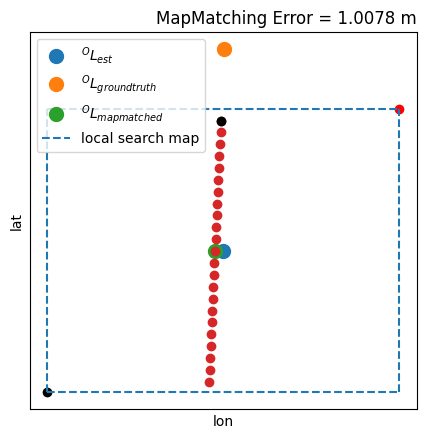

In [41]:
error = geodesic(point_mm, point_gt).meters
plt.figure(figsize=(5, 5))
plt.scatter(point.longitude, point.latitude, s=100, label=r'$^OL_{est}$')
plt.scatter(point_gt.longitude, point_gt.latitude, s=100, label=r'$^OL_{ground truth}$')
plt.scatter(point_mm.longitude, point_mm.latitude, s=100, label=r'$^OL_{mapmatched}$')

plt.hlines(y=bound1.latitude, xmin=bound2.longitude, xmax=bound1.longitude, linestyles='--', label=r'local search map')
plt.vlines(x=bound2.longitude, ymin=bound2.latitude, ymax=bound1.latitude, linestyles='--')
plt.hlines(y=bound2.latitude, xmin=bound2.longitude, xmax=bound1.longitude, linestyles='--')
plt.vlines(x=bound1.longitude, ymin=bound2.latitude, ymax=bound1.latitude, linestyles='--')

plt.scatter(bound1.longitude, bound1.latitude, color='red')
plt.scatter(bound2.longitude, bound2.latitude, color='black')

plt.scatter(local_map['left_mark_lon'], local_map['left_mark_lat'])
plt.scatter(local_map['left_mark_lon'].values[0], local_map['left_mark_lat'].values[0], color='black')
plt.xlabel('lon')
plt.ylabel('lat')

plt.title(f'MapMatching Error = {round(error, 4)} m', loc='right')
plt.legend()
plt.ticklabel_format(useOffset=False)
plt.xticks([])
plt.yticks([])
plt.show()


## Method 2: Build Local Map Based on Distance Traveled

In [22]:
def traj_speed_integration(vx: np.ndarray, fs=10) -> float:
    """
    vs: the trajectory speed, containing the longitudinal speed trajectory from the start to the current time step
    fs: sampling frequency, default to 10hz
    """
    Ts = 1/fs # sampling interval
    dist_est = scipy.integrate.cumtrapz(vx, dx=Ts, initial=0)[-1]

    return dist_est

In [64]:
def map_matching(lane_ref, est, delta, lanemark='left', method=1):
    """
    lane_ref: the unsampled reference lanemark dataframe
    est: the sampled noisy estimated lanemark dataframe
    delta: local search map size, [m]
    
    main function to perform map-matching and append the matched reference points in est
    """

    ref_opt_lat = []
    ref_opt_lon = []
    local_map_size = []

    for idx in tqdm(range(est.shape[0])):
        if method == 1:
            # build local search map around est L
            est_point = geopy.Point(est[f'{lanemark}_mark_lat_noise'].values[idx], 
                                    est[f'{lanemark}_mark_lon_noise'].values[idx])
        else:
            # integrate sampled trajectory velocity and find the ref lanemark point with 
            # the closest traveled distance 
            est_traj_dist = traj_speed_integration(est.iloc[:idx+1, ]['Vx'])
            lane_ref_to_dist = lane_ref[lane_ref['Distance horizontal (m)'] <= est_traj_dist].iloc[-1]
            est_point = geopy.Point(lane_ref_to_dist[f'{lanemark}_mark_lat'], 
                                    lane_ref_to_dist[f'{lanemark}_mark_lon'])
        try:
            local_map = build_m(lane_ref, est_point, delta)
        except:
            print('idx:', idx)
            break
        
        local_map_size.append(local_map.shape[0])
        ref_opt = get_cloest_ref(local_map, est_point)
        ref_opt_lat.append(ref_opt[0])
        ref_opt_lon.append(ref_opt[1])

    est[f'{lanemark}_mark_lat_mm'] = ref_opt_lat
    est[f'{lanemark}_mark_lon_mm'] = ref_opt_lon

    return est, local_map_size

In [65]:
ll_mapmatch, local_map_sizes = map_matching(ll_marks, ll_sampled_noise, delta=1, method=2)

100%|██████████| 7082/7082 [00:41<00:00, 169.96it/s]


In [63]:
ll_mapmatch

,y,x,Vx,left_mark_lat,left_mark_lon,right_mark_lat,right_mark_lon,Distance horizontal (m),left_mark_lat_noise,left_mark_lon_noise,right_mark_lat_noise,right_mark_lon_noise,left_mark_lat_ref_mm,left_mark_lon_ref_mm
0,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557465,42.238662,0.000,-83.557431,42.238624,-83.557465,42.238663,-83.557432,42.238624
10,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557465,42.238662,0.001,-83.557433,42.238626,-83.557465,42.238661,-83.557432,42.238624
20,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557464,42.238662,0.002,-83.557426,42.238619,-83.557467,42.238668,-83.557432,42.238624
30,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557464,42.238662,0.003,-83.557433,42.238620,-83.557465,42.238662,-83.557432,42.238624
40,42.238643,-83.557448,0.01,-83.557432,42.238624,-83.557464,42.238662,0.004,-83.557432,42.238618,-83.557465,42.238663,-83.557432,42.238624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70770,42.238652,-83.557370,2.86,-83.557354,42.238634,-83.557387,42.238670,3704.185,-83.557351,42.238627,-83.557389,42.238673,-83.557354,42.238634
70780,42.238652,-83.557367,2.77,-83.557351,42.238634,-83.557383,42.238670,3704.467,-83.557348,42.238636,-83.557381,42.238673,-83.557351,42.238634
70790,42.238652,-83.557364,2.69,-83.557347,42.238634,-83.557380,42.238670,3704.740,-83.557346,42.238634,-83.557380,42.238672,-83.557347,42.238634
70800,42.238653,-83.557360,2.60,-83.557344,42.238635,-83.557377,42.238671,3705.004,-83.557346,42.238633,-83.557380,42.238669,-83.557344,42.238635


In [66]:
ll_mapmatch_error_l = traj_gps_error(
    ll_mapmatch, 
    colns1=['left_mark_lat', 'left_mark_lon'], colns2=['left_mark_lat_mm', 'left_mark_lon_mm']
)
print(ll_mapmatch_error_l.mean(), ll_mapmatch_error_l.std())

0.005846327495678508 0.016772708425344125


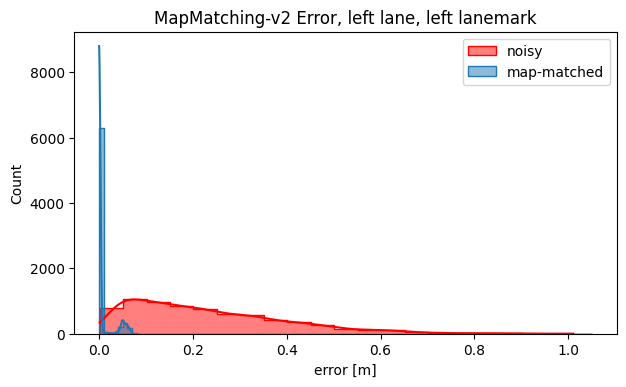

In [39]:
plt.figure(figsize=(7, 4), dpi=100)
sns.histplot(ll_mark_error_l, binwidth=0.05, label='noisy', kde=True, color='red', element = "step")
sns.histplot(ll_mapmatch_error_l, binwidth=0.01, label='map-matched', kde=True, element = "step")
plt.legend()
plt.xlabel('error [m]')
plt.title('MapMatching-v2 Error, left lane, left lanemark')
plt.show()

In [67]:
def plot_mm_result(
    delta, 
    sample_idx: int, 
    ref_df: pd.DataFrame,
    matched_df: pd.DataFrame,
    lanemark='left',
    ) -> None:

    sample = matched_df.iloc[sample_idx]
    point_est = geopy.Point(sample[f'{lanemark}_mark_lat_noise'], sample[f'{lanemark}_mark_lon_noise'])
    point_mm = geopy.Point(sample[f'{lanemark}_mark_lat_mm'], sample[f'{lanemark}_mark_lon_ref_mm'])
    point_gt = geopy.Point(sample[f'{lanemark}_mark_lat'], sample[f'{lanemark}_mark_lon'])

    # top right
    bound1 = geodesic(meters=delta/2).destination(
        point_est, bearing=45
    )
    # bottom left
    bound2 = geodesic(meters=delta/2).destination(
        point_est, bearing=225
    )

    local_map = ref_df[(ref_df['left_mark_lat'] <= bound1.latitude) &\
            (ref_df['left_mark_lat'] >= bound2.latitude) &\
            (ref_df['left_mark_lon'] <= bound1.longitude) &\
            (ref_df['left_mark_lon'] >= bound2.longitude)]
    
    mm_error = geodesic(point_mm, point_gt).meters
    plt.figure(figsize=(5, 5), dpi=100)
    plt.scatter(point_est.longitude, point_est.latitude, s=100, label=r'$^OL_{est}$')
    plt.scatter(point_gt.longitude, point_gt.latitude, s=100, label=r'$^OL_{ground truth}$')
    plt.scatter(point_mm.longitude, point_mm.latitude, s=100, label=r'$^OL_{mapmatched}$')

    plt.hlines(y=bound1.latitude, xmin=bound2.longitude, xmax=bound1.longitude, linestyles='--', label=r'local search map')
    plt.vlines(x=bound2.longitude, ymin=bound2.latitude, ymax=bound1.latitude, linestyles='--')
    plt.hlines(y=bound2.latitude, xmin=bound2.longitude, xmax=bound1.longitude, linestyles='--')
    plt.vlines(x=bound1.longitude, ymin=bound2.latitude, ymax=bound1.latitude, linestyles='--')

    plt.scatter(bound1.longitude, bound1.latitude, color='red')
    plt.scatter(bound2.longitude, bound2.latitude, color='black')

    plt.scatter(local_map['left_mark_lon'], local_map['left_mark_lat'])
    plt.scatter(local_map['left_mark_lon'].values[0], local_map['left_mark_lat'].values[0], color='black')
    plt.xlabel('lon')
    plt.ylabel('lat')

    plt.title(f'Method 2: MapMatching Error = {round(mm_error, 4)} m', loc='right')
    plt.legend()
    plt.ticklabel_format(useOffset=False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

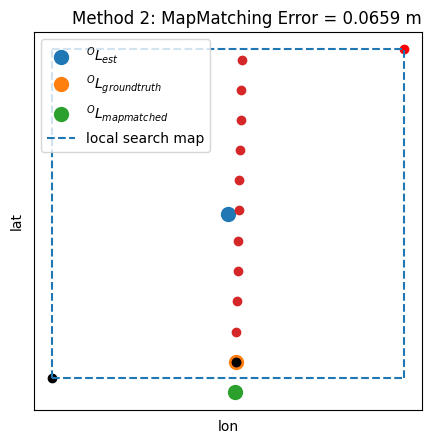

In [74]:
sample_idx = np.argmax(ll_mapmatch_error_l)
plot_mm_result(1, np.random.randint(3000), ll_marks, ll_mapmatch)

## Algorithm Testing

### Trajectory Segments

- Generate 500 samples of trajectory segments for the left and right lanes with random start and fixed length distribution
- Randomly pick a noisy coordinate along each segment for map-matching, and evaluate the results.